### Gymnasium links

Announce: https://farama.org/Announcing-The-Farama-Foundation

Github: https://github.com/Farama-Foundation/Gymnasium

Documentation: https://gymnasium.farama.org/

# Deep Crossentropy method

In this section we'll extend your CEM implementation with neural networks! You will train a multi-layer neural network to solve simple continuous state space games. __Please make sure you're done with tabular crossentropy method from the previous notebook.__


In [ ]:
# Install gymnasium if you don't have
#!pip install gymnasium
#!pip install gymnasium[toy_text]
#!pip install gymnasium[classic_control]
#!pip install imageio_ffmpeg

In [1]:
# Чтобы сохранение видео работало
import os
from pathlib import Path
venv_dir = Path('/Users/user/Library/Caches/pypoetry/virtualenvs/rl-course-gaLdOzXs-py3.9')
ffmpeg_binary_fp = venv_dir / 'lib/python3.9/site-packages/imageio_ffmpeg/binaries/ffmpeg-osx64-v4.2.2'
os.environ['FFMPEG_BINARY'] = str(ffmpeg_binary_fp)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
state vector dim = 4
n_actions = 2


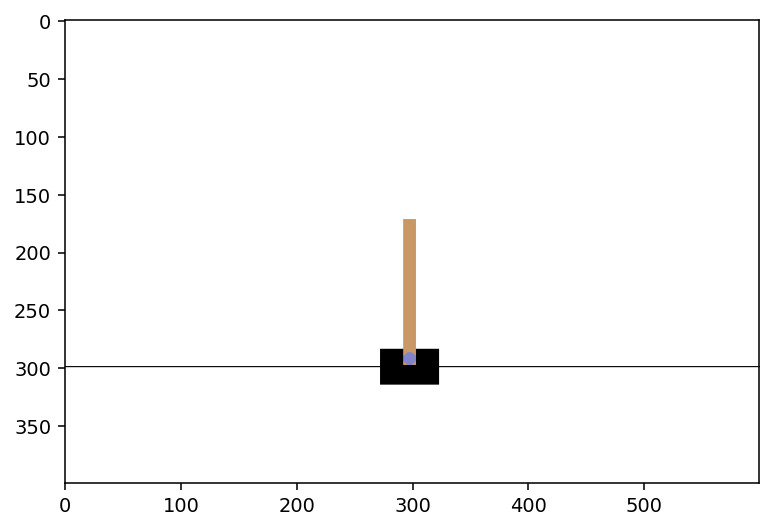

In [77]:
import random
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
# Более высокое качество графиков
%config InlineBackend.figure_format='retina'
plt.rcParams["figure.dpi"] = 70
import gymnasium as gym
# Автоматическая загрузка изменений модулей
%load_ext autoreload
%autoreload 2
# Для удобства использования функции для обучения были объединены в один объект
from gym_pipe import GymPipeline

def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)


env_name = 'CartPole-v1'
pipe = GymPipeline(env_name)
env = pipe.get_env()
env.reset()

state_dim = env.observation_space.shape[0]

plt.imshow(env.render())
print("state vector dim =", state_dim)
print("n_actions =", pipe.n_actions)

env.close()

In [12]:
env.observation_space, env.action_space

(Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32),
 Discrete(2))

# Neural Network Policy

For this assignment we'll utilize the simplified neural network implementation from __[Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)__. Here's what you'll need:

* `agent.partial_fit(states, actions)` - make a single training pass over the data. Maximize the probabilitity of :actions: from :states:
* `agent.predict_proba(states)` - predict probabilities of all actions, a matrix of shape __[len(states), n_actions]__

You may also use your favorite neural framework, if it doesn't make it too difficult. The idea is the main thing.

In [78]:
agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
)

pipe.agent = agent

In [79]:
dummy_states, dummy_actions, dummy_reward = pipe.generate_session(max_iter_per_session=5)
print("states:", np.stack(dummy_states))
print("actions:", dummy_actions)
print("reward:", dummy_reward)

states: [[ 0.03750519  0.01340863 -0.04077885 -0.03346933]
 [ 0.03777336  0.20909092 -0.04144824 -0.33873442]
 [ 0.04195518  0.4047774  -0.04822293 -0.6441943 ]
 [ 0.05005072  0.60053706 -0.06110681 -0.9516645 ]
 [ 0.06206147  0.40628833 -0.0801401  -0.6787895 ]]
actions: [1, 1, 1, 0, 1]
reward: 5.0


### CEM steps
Deep CEM uses exactly the same strategy as the regular CEM, so you can copy your function code from previous notebook.

The only difference is that now each observation is not a number but a `float32` vector.

Let's see that it differs from tabular `select_elites`. Our neural network now is trained with one object and it takes an input of `(1, n_states)`. So, we should use `np.squeeze` to remove leading dimension in the deep `select_elites`.


# Training loop
Generate sessions, select N best and fit to those.

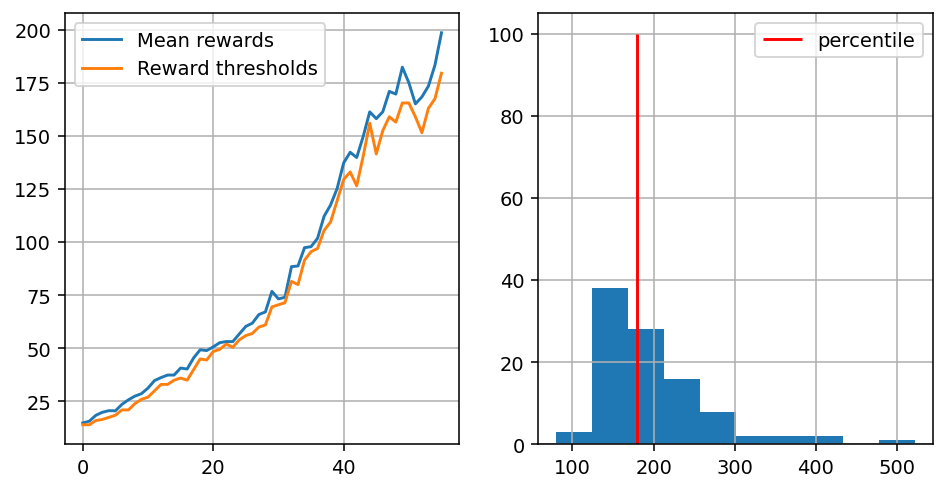

mean reward = 198.540, threshold=179.500
Training time for last epoch: 3.01 seconds

You Win!


In [82]:
epochs = 100
n_sessions = 100
n_sessions_in_epoch = 100
percentile = 50

set_seed()
pipe.train(
    epochs=epochs,
    n_sessions_in_epoch=n_sessions_in_epoch,
    percentile=percentile
)

# Results

In [ ]:
from gymnasium.wrappers.record_video import RecordVideo
env = gym.make('CartPole-v1', render_mode="rgb_array")
env = RecordVideo(env, './videos', episode_trigger = lambda episode_number: True)

sessions = [pipe.generate_session(1000, test=True) for _ in range(5)]
env.close()

In [ ]:
# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1]))  # this may or may not be _last_ video. Try other indices

# Homework

### Deep crossentropy method

By this moment you should have got enough score on [CartPole-v1](https://gymnasium.farama.org/environments/classic_control/cart_pole/) to consider it solved (see the link). It's time to try something harder.

* if you have any trouble with CartPole-v1 and feel stuck, feel free to ask us or your peers for help.

### Tasks (up to 1 point each)

* __2.1__ Pick one of environments: MountainCar-v0 or LunarLander-v2.
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__

See the tips section below, it's kinda important.
__Note:__ If your agent is below the target score, you'll still get most of the points depending on the result, so don't be afraid to submit it.
  
  
* __2.2__ Devise a way to speed up training at least 2x against the default version
  * Obvious improvement: use [joblib](https://www.google.com/search?client=ubuntu&channel=fs&q=joblib&ie=utf-8&oe=utf-8) or multiprocessing
  * Try re-using samples from 3-5 last iterations when computing threshold and training
  * Experiment with amount of training iterations and learning rate of the neural network (see params)
  
  
### Tips
* Gym page: [MountainCar](https://gymnasium.farama.org/environments/classic_control/mountain_car/), [LunarLander](https://gymnasium.farama.org/environments/box2d/lunar_lander/)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 20% are better, than if you use percentile 20% as threshold, R >= threshold __fails cut off bad sessions__ whule R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it won't train it's a good idea to plot reward distribution and record sessions: they may give you some clue. If they don't, call course staff :)
* 20-neuron network is probably not enough, feel free to experiment.

You may find the following snippet useful:

In [23]:
def visualize_mountain_car(env, agent):
    xs = np.linspace(env.min_position, env.max_position, 100)
    vs = np.linspace(-env.max_speed, env.max_speed, 100)
    grid = np.dstack(np.meshgrid(xs, vs)).transpose(1, 0, 2)
    grid_flat = grid.reshape(len(xs) * len(vs), 2)
    probs = agent.predict_proba(grid_flat).reshape(len(xs), len(vs), 3)
    return probs

#plt.imshow(visualize_mountain_car(env, agent))

### LunarLander - базовое решение

state vector dim = 8
n_actions = 4


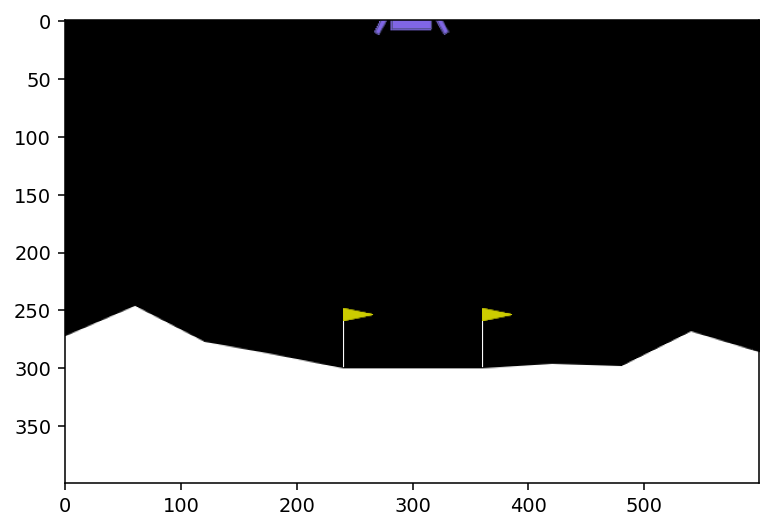

In [49]:
env_name = 'LunarLander-v2'
pipe = GymPipeline(env_name)
env = pipe.get_env()
env.reset()
state_dim = env.observation_space.shape[0]

plt.imshow(env.render())
print("state vector dim =", state_dim)
print("n_actions =", pipe.n_actions)

env.close()

In [50]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
    max_iter=800,  # Default value 200
)

pipe.agent = agent

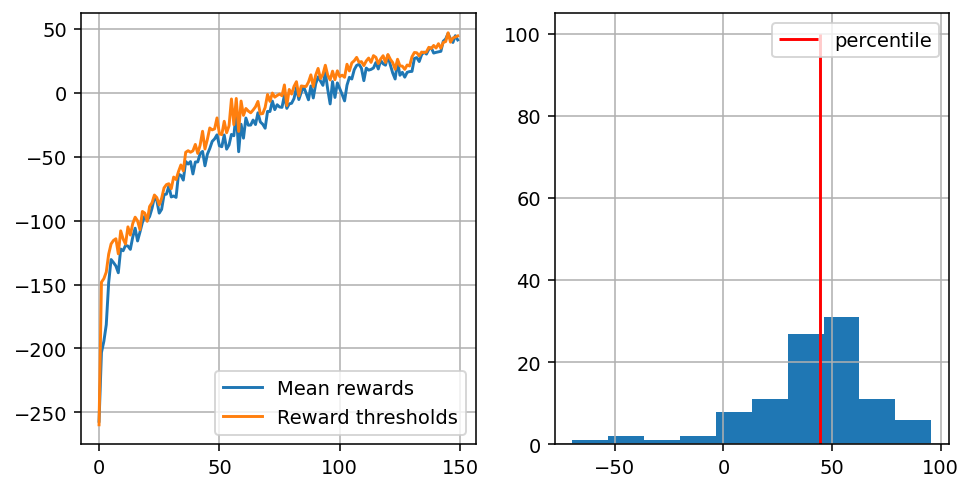

mean reward = 41.224, threshold=44.363
Training time for last epoch: 65.55 seconds

CPU times: user 58min 49s, sys: 33.9 s, total: 59min 23s
Wall time: 59min 4s


In [45]:
epochs = 150
n_sessions_in_epoch = 100
percentile = 50

set_seed()
%time pipe.train(epochs=epochs, n_sessions_in_epoch=n_sessions_in_epoch, percentile=percentile)

### LunarLander - оптимизация

Для оптимизации был использован multiprocessing.Pool при создании сессий, а также был сделан реюз 20 лучших по награде сессий (по второму см. gym_pipe.GymPipelineOptimized)

In [75]:
from gym_pipe import GymPipelineOptimized

agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
    solver='adam',  # Default adam
    learning_rate_init=0.001,  # Default 0.001
    #learning_rate='adaptive',  # Only with sgd
    max_iter=800,  # Default 200
)

pipe = GymPipelineOptimized(env_name, agent, top_rewards_to_reuse=20)

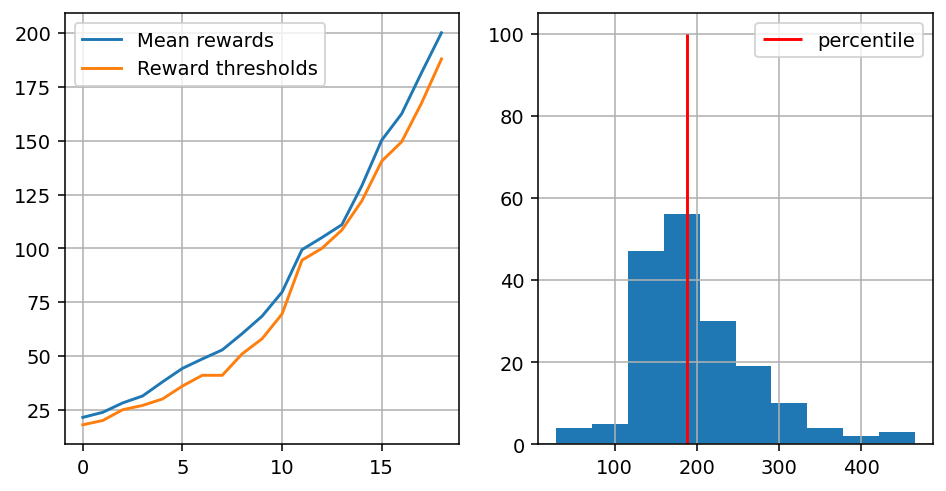

mean reward = 200.183, threshold=188.000
Training time for last epoch: 4.34 seconds

You Win!
CPU times: user 32 s, sys: 3.84 s, total: 35.9 s
Wall time: 59.6 s


In [76]:
epochs = 150
n_sessions_in_epoch = 100
percentile = 50
n_jobs = 5  # Колво процессов при создании сессий

set_seed()
%time pipe.train(epochs=epochs, n_sessions_in_epoch=n_sessions_in_epoch, percentile=percentile, n_jobs=n_jobs, seed=0)

### Bonus tasks (up to 0.5 points)

* __2.3 bonus__ Solve continuous action space task with `MLPRegressor` or similar.
  * Start with ["Pendulum-v1"](https://gymnasium.farama.org/environments/classic_control/pendulum/) __(score -150)__.
  * Since your agent only predicts the "expected" action, you will have to add noise to ensure exploration.
  * Solve [MountainCarContinuous-v0](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/) __(score +90)__ or [LunarLanderContinuous-v2](https://gymnasium.farama.org/environments/box2d/lunar_lander/) __(score -200)__. Slightly less points for getting some results below solution threshold. Note that discrete and continuous environments may have slightly different rules aside from action spaces.
  * __Please list what you did in anytask submission form__